In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
top_data_df = pd.read_csv('/content/gdrive/MyDrive/IMDB Dataset.csv')
print("Columns in the original dataset:\n")
top_data_df.head()
top_data_df['sentiment'] = top_data_df['sentiment'].replace({'positive':1, 'negative':0}).astype(int) 
top_data_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Columns in the original dataset:



,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Number of rows per star rating:
1    25000
0    25000
Name: sentiment, dtype: int64


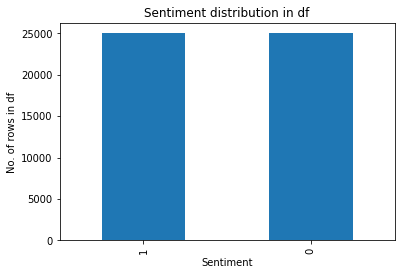

In [ ]:
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(top_data_df['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [ ]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=5000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
1    5000
0    5000
Name: sentiment, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
9,If you like original gut wrenching laughter yo...,1
14,This a fantastic movie of three prisoners who ...,1
16,Some films just simply should not be remade. T...,1
18,"I remember this film,it was the first film i h...",1


In [ ]:
# Removing the stop words
#from gensim.parsing.preprocessing import remove_stopwords
#print(remove_stopwords("Restaurant had a really good service!!"))
#print(remove_stopwords("I did not like the food!!"))
#print(remove_stopwords("This product is not good!!"))

In [ ]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['review']] 
print(top_data_df_small['tokenized_text'].head(10))

0     [one, of, the, other, reviewers, has, mentione...
1     [wonderful, little, production, br, br, the, f...
2     [thought, this, was, wonderful, way, to, spend...
4     [petter, mattei, love, in, the, time, of, mone...
5     [probably, my, all, time, favorite, movie, sto...
6     [sure, would, like, to, see, resurrection, of,...
9     [if, you, like, original, gut, wrenching, laug...
14    [this, fantastic, movie, of, three, prisoners,...
16    [some, films, just, simply, should, not, be, r...
18    [remember, this, film, it, was, the, first, fi...
Name: tokenized_text, dtype: object


In [ ]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

0     [on, of, the, other, review, ha, mention, that...
1     [wonder, littl, product, br, br, the, film, te...
2     [thought, thi, wa, wonder, wai, to, spend, tim...
4     [petter, mattei, love, in, the, time, of, mone...
5     [probabl, my, all, time, favorit, movi, stori,...
6     [sure, would, like, to, see, resurrect, of, up...
9     [if, you, like, origin, gut, wrench, laughter,...
14    [thi, fantast, movi, of, three, prison, who, b...
16    [some, film, just, simpli, should, not, be, re...
18    [rememb, thi, film, it, wa, the, first, film, ...
Name: stemmed_tokens, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
0    4012
1    3988
Name: sentiment, dtype: int64
Value counts for Test sentiments
1    1012
0     988
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                     stemmed_tokens
0   1863  [the, origin, femal, convict, scorpion, is, an...
1    350  [man, with, the, scream, brain, certainli, isn...
2   2544  [well, now, here, the, thing, for, thi, movi, ...
3   8046  [total, agre, with, the, other, poster, nemesi...
4   4074  [the, idea, of, bring, dracula, to, contempora...


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1: vocab_size --> 500
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 500 --> 500
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3: 500 --> 500
        self.fc3 = nn.Linear(hidden_dim, hidden_dim) 
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Linear function 4: 500 --> 500
        self.fc4 = nn.Linear(hidden_dim, hidden_dim) 
        # Non-linearity 4
        self.relu4 = nn.ReLU()

        # Linear function 5 (readout): 500 --> 3
        self.fc5 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)

        # Linear function 5 (readout)
        out = self.fc5(out)

        return F.softmax(out, dim=1)


In [ ]:
from gensim import corpora
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(top_data_df_small, padding=False)

Dictionary without padding


In [ ]:
VOCAB_SIZE = len(review_dict)
NUM_LABELS = 2

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

In [ ]:
# Function to get the output tensor
def make_target(label):
    if label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
  

In [ ]:
VOCAB_SIZE = len(review_dict)

print(VOCAB_SIZE)
input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 2
num_epochs = 10

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.001)

34954


In [ ]:
# Open the file for writing loss
ffnn_loss_file_name = '/content/gdrive/MyDrive/ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 5 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = ff_nn_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

Epoch completed: 5
Epoch completed: 10


              precision    recall  f1-score   support

           0       0.81      0.91      0.86       988
           1       0.90      0.79      0.84      1012

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000

10
Index(['iter', ' loss'], dtype='object')


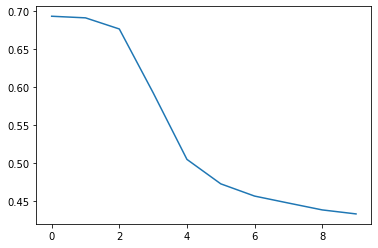

In [ ]:
from sklearn.metrics import classification_report
nn_predictions = []
original_lables_ff_bow = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow,nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()